## CNN 모델

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from collections import Counter

In [11]:
# 하이퍼파라미터 설정
num_epochs = 10
batch_size = 32
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 전처리 과정

1. **데이터 전처리**
    - `torchvision.transforms` 모듈을 활용하여 학습 및 테스트 데이터를 각각 전처리
        - **Resize**: 이미지를 `(224, 224)`로 크기 조정
        - **ToTensor**: 이미지를 텐서 형식으로 변환
        - **Normalize**: 각 채널의 평균과 표준편차를 사용하여 정규화 진행 (`mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`)

2. **DataLoader 설정**
    - `DataLoader`를 사용하여 학습, 검증, 테스트 데이터를 배치 크기에 맞게 불러오기
        - `dataset`: 각 데이터셋의 경로를 지정하여 어떤 데이터를 사용할 것인지 결정
        - `batch_size`: 미니 배치 크기를 설정하여 학습 속도를 조절
        - `shuffle`: 학습 데이터는 랜덤으로 섞어서 일반화 성능을 높이며, 검증 및 테스트 데이터는 섞지 않고 그대로 사용

In [12]:
# 데이터셋 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# 데이터셋 로드
train_dataset = ImageFolder(root='./cnn_dataset/Training', transform=transform)
test_dataset = ImageFolder(root='./cnn_dataset/Test', transform=transform)
val_dataset = ImageFolder(root='./cnn_dataset/Validation', transform=transform)

In [14]:
# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# 모델 정의

In [15]:
# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # 배치 정규화 추가
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # 배치 정규화 추가
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # 배치 정규화 추가
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout2d(0.3)  # 드롭아웃 추가

        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 12)
        self.dropout_fc = nn.Dropout(0.5)

        # ReLU 활성화 함수 정의
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # ReLU 및 배치 정규화
        x = self.dropout_conv(x)  # 드롭아웃
        x = self.pool(self.relu(self.bn2(self.conv2(x))))  # ReLU 및 배치 정규화
        x = self.dropout_conv(x)  # 드롭아웃
        x = self.pool(self.relu(self.bn3(self.conv3(x))))  # ReLU 및 배치 정규화
        x = self.dropout_conv(x)  # 드롭아웃
        
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))  # ReLU
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)

In [16]:
# 클래스별 샘플 개수 계산
class_counts = Counter([label for _, label in train_dataset.samples])
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(len(train_dataset.classes))], dtype=torch.float)

class_weights = class_weights.to(device)

# 가중치 적용된 손실 함수 정의
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(class_weights)

tensor([0.0007, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008, 0.0008], device='cuda:0')


In [ ]:
# TensorBoard 설정
##❗학습마다 다르게 설정해야 함
writer = SummaryWriter('./runs/basic_cnn_2/')

In [18]:
# 학습 루프
best_val_acc = 0
best_model = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total

    # 검증
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total

    # TensorBoard에 로그 기록
    writer.add_scalar('Loss/train', running_loss / len(train_loader), epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Loss/validation', val_loss / len(val_loader), epoch)
    writer.add_scalar('Accuracy/validation', val_acc, epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, '
          f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

    # 최고 성능 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()
    
# 최고 성능 모델 저장
torch.save(best_model, 'best_cnn_model.pth')
writer.close()

Epoch [1/10], Train Loss: 3.6099, Train Acc: 15.85%, Val Acc: 28.43%
Epoch [2/10], Train Loss: 2.2371, Train Acc: 19.87%, Val Acc: 33.62%
Epoch [3/10], Train Loss: 2.1342, Train Acc: 23.72%, Val Acc: 41.84%
Epoch [4/10], Train Loss: 2.0965, Train Acc: 24.30%, Val Acc: 41.62%
Epoch [5/10], Train Loss: 2.0392, Train Acc: 26.36%, Val Acc: 39.78%
Epoch [6/10], Train Loss: 2.0134, Train Acc: 26.86%, Val Acc: 42.59%
Epoch [7/10], Train Loss: 2.0213, Train Acc: 26.85%, Val Acc: 41.19%
Epoch [8/10], Train Loss: 1.9781, Train Acc: 28.35%, Val Acc: 42.38%
Epoch [9/10], Train Loss: 1.9577, Train Acc: 28.95%, Val Acc: 40.43%
Epoch [10/10], Train Loss: 1.9252, Train Acc: 30.60%, Val Acc: 45.30%


In [19]:
# 테스트 셋으로 평가
model.load_state_dict(torch.load('best_cnn_model.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct / total
print(f'Test Accuracy: {test_acc:.2f}%')

C:\Users\ho_e_\AppData\Local\Temp\ipykernel_31736\2630783028.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn_model.pth'))


Test Accuracy: 41.15%


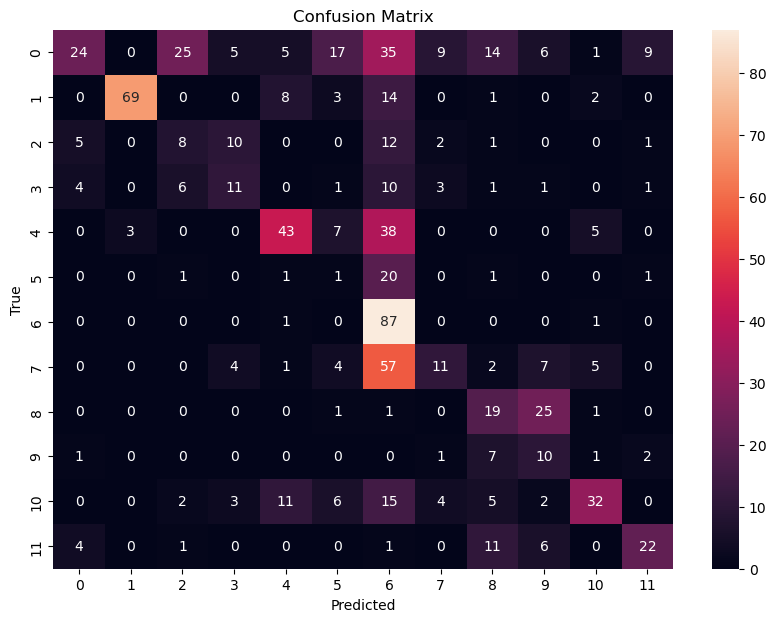

In [20]:
# 혼동 행렬 시각화
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [4]:
# TensorBoard 실행 (주석 처리된 상태)
%reload_ext tensorboard
%tensorboard --logdir './runs/' --port 6009

Reusing TensorBoard on port 6009 (pid 15184), started 0:00:07 ago. (Use '!kill 15184' to kill it.)